# PyTorch Regression Example

## Dataset

In [1]:
import numpy as np

X_train = np.array(
    [258.0, 270.0, 294.0, 320.0, 342.0, 368.0, 396.0, 446.0, 480.0, 586.0]
)[:, np.newaxis]

y_train = np.array(
    [236.4, 234.4, 252.8, 298.6, 314.2, 342.2, 360.8, 368.0, 391.2, 390.8]
)

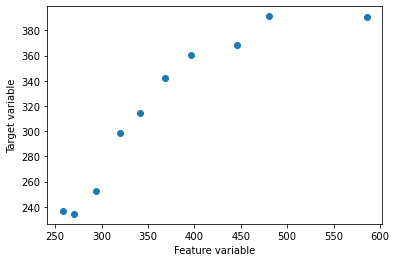

In [2]:
import matplotlib.pyplot as plt

plt.scatter(X_train, y_train)
plt.xlabel("Feature variable")
plt.ylabel("Target variable")
plt.show()

## Linear Regression

In [3]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

# create predictions for plotting
X_train_range = np.arange(250, 600, 10)[:, np.newaxis]
y_linear = lr.predict(X_train_range)

/Users/sebastianraschka/miniforge3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


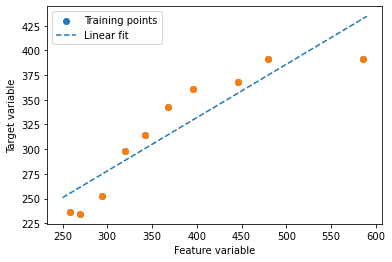

In [4]:
# plot results
plt.scatter(X_train, y_train, label="Training points")
plt.plot(X_train_range, y_linear, label="Linear fit", linestyle="--")

plt.scatter(X_train, y_train)
plt.xlabel("Feature variable")
plt.ylabel("Target variable")
plt.legend()
plt.show()

## Polynomial Regression

In [5]:
from sklearn.preprocessing import PolynomialFeatures

pr = LinearRegression()

quadratic = PolynomialFeatures(degree=2)
quadratic.fit(X_train)
X_train_quad = quadratic.transform(X_train)

pr.fit(X_train_quad, y_train);

In [6]:
y_quadratic = pr.predict(quadratic.transform(X_train_range))

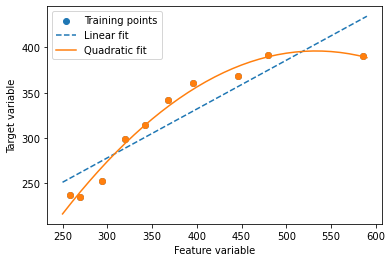

In [7]:
# plot results
plt.scatter(X_train, y_train, label="Training points")
plt.plot(X_train_range, y_linear, label="Linear fit", linestyle="--")
plt.plot(X_train_range, y_quadratic, label="Quadratic fit")

plt.scatter(X_train, y_train)
plt.xlabel("Feature variable")
plt.ylabel("Target variable")
plt.legend()
plt.show()

## Multilayer Perceptron

### Define model

In [8]:
import torch


class PyTorchMLP(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()

        self.all_layers = torch.nn.Sequential(
            # 1st hidden layer
            torch.nn.Linear(num_features, 50),
            torch.nn.ReLU(),
            # 2nd hidden layer
            torch.nn.Linear(50, 25),
            torch.nn.ReLU(),
            # output layer
            torch.nn.Linear(25, 1),
        )

    def forward(self, x):
        logits = self.all_layers(x).flatten()
        return logits

#### Normalize data

In [9]:
x_mean, x_std = X_train.mean(), X_train.std()
y_mean, y_std = y_train.mean(), y_train.std()

X_train_norm = (X_train - x_mean) / x_std
y_train_norm = (y_train - y_mean) / y_std

### Set up dataloader

In [10]:
from torch.utils.data import DataLoader, Dataset


class MyDataset(Dataset):
    def __init__(self, X, y):

        self.features = torch.tensor(X, dtype=torch.float32)
        self.targets = torch.tensor(y, dtype=torch.float32)

    def __getitem__(self, index):
        x = self.features[index]
        y = self.targets[index]
        return x, y

    def __len__(self):
        return self.targets.shape[0]


train_ds = MyDataset(X_train_norm, y_train_norm)

train_loader = DataLoader(
    dataset=train_ds,
    batch_size=20,
    shuffle=True,
)

### Train model

In [11]:
import torch.nn.functional as F

torch.manual_seed(1)
model = PyTorchMLP(num_features=1)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

num_epochs = 50

loss_list = []
train_acc_list, val_acc_list = [], []
for epoch in range(num_epochs):

    model = model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):

        logits = model(features)
        loss = F.mse_loss(logits, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if not batch_idx % 250:
            ### LOGGING
            print(
                f"Epoch: {epoch+1:03d}/{num_epochs:03d}"
                f" | Batch {batch_idx:03d}/{len(train_loader):03d}"
                f" | Train Loss: {loss:.2f}"
            )
        loss_list.append(loss.item())

Epoch: 001/050 | Batch 000/001 | Train Loss: 0.95
Epoch: 002/050 | Batch 000/001 | Train Loss: 0.68
Epoch: 003/050 | Batch 000/001 | Train Loss: 0.47
Epoch: 004/050 | Batch 000/001 | Train Loss: 0.29
Epoch: 005/050 | Batch 000/001 | Train Loss: 0.17
Epoch: 006/050 | Batch 000/001 | Train Loss: 0.11
Epoch: 007/050 | Batch 000/001 | Train Loss: 0.09
Epoch: 008/050 | Batch 000/001 | Train Loss: 0.07
Epoch: 009/050 | Batch 000/001 | Train Loss: 0.06
Epoch: 010/050 | Batch 000/001 | Train Loss: 0.06
Epoch: 011/050 | Batch 000/001 | Train Loss: 0.05
Epoch: 012/050 | Batch 000/001 | Train Loss: 0.04
Epoch: 013/050 | Batch 000/001 | Train Loss: 0.04
Epoch: 014/050 | Batch 000/001 | Train Loss: 0.04
Epoch: 015/050 | Batch 000/001 | Train Loss: 0.03
Epoch: 016/050 | Batch 000/001 | Train Loss: 0.03
Epoch: 017/050 | Batch 000/001 | Train Loss: 0.03
Epoch: 018/050 | Batch 000/001 | Train Loss: 0.02
Epoch: 019/050 | Batch 000/001 | Train Loss: 0.02
Epoch: 020/050 | Batch 000/001 | Train Loss: 0.02


### Normalize "new" data

In [12]:
X_trainrange_norm = (X_train_range - x_mean) / x_std
X_trainrange_norm = torch.tensor(X_trainrange_norm, dtype=torch.float32)

model.eval()

# predict
y_mlp_norm = model(X_trainrange_norm)
y_mlp_norm = y_mlp_norm.detach().numpy().astype(np.float64)

# MLP returns normalized predictions
# undo normalization of preditions for plotting
y_mlp = y_mlp_norm * y_std + y_mean

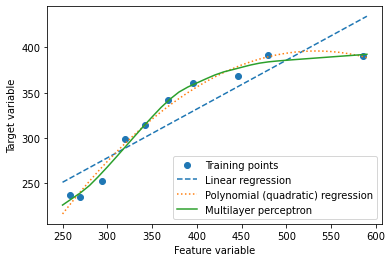

In [13]:
# plot results
plt.scatter(X_train, y_train, label="Training points")
plt.plot(X_train_range, y_linear, label="Linear regression", linestyle="--")
plt.plot(
    X_train_range, y_quadratic, label="Polynomial (quadratic) regression", linestyle=":"
)
plt.plot(X_train_range, y_mlp, label="Multilayer perceptron")

plt.xlabel("Feature variable")
plt.ylabel("Target variable")
plt.legend()
plt.show()

## Extrapolating outside the training set range

In [14]:
# create predictions for plotting
X_outrange = np.arange(-1000, 2000, 10)[:, np.newaxis]

In [15]:
# linear regression
y_linear = lr.predict(X_outrange)

In [16]:
# quadratic regression
y_quadratic = pr.predict(quadratic.transform(X_outrange))

In [17]:
# mlp
X_outrange_norm = (X_outrange - x_mean) / x_std
X_outrange_norm = torch.tensor(X_outrange_norm, dtype=torch.float32)

# predict
y_mlp_norm = model(X_outrange_norm)
y_mlp_norm = y_mlp_norm.detach().numpy().astype(np.float64)

# MLP returns normalized predictions
# undo normalization of preditions for plotting
y_mlp = y_mlp_norm * y_std + y_mean

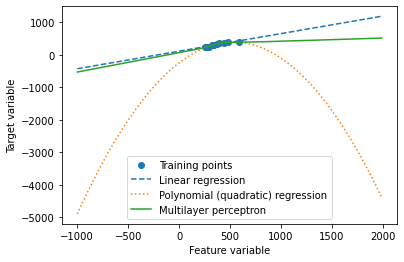

In [18]:
# plot results
plt.scatter(X_train, y_train, label="Training points")
plt.plot(X_outrange, y_linear, label="Linear regression", linestyle="--")
plt.plot(
    X_outrange, y_quadratic, label="Polynomial (quadratic) regression", linestyle=":"
)
plt.plot(X_outrange, y_mlp, label="Multilayer perceptron")

plt.xlabel("Feature variable")
plt.ylabel("Target variable")
plt.legend()
plt.show()

---

In [19]:
%load_ext watermark
%watermark -iv

torch     : 1.12.1
matplotlib: 3.5.2
numpy     : 1.22.1

